In [0]:
# !! If you will use the google collab for running codes in this document
# you need the uncommented section !!!
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
pip install barbar # Only for google collab !!!

## CNN and LSTM methods 

### Data preparation

Import all rquired libraries:

In [9]:
import pandas as pd
import numpy as np
#import torch # required for Neural Nets
# import torch.nn as nn # required for Neural Nets
# import torch.utils.data as data_utils # required for Neural Nets
import os
#import progressbar # progress bar
#from barbar import Bar # progress bar for Neural Nets
import pickle # For saving variables and models
from sklearn.model_selection import train_test_split # for splitting into training and test data sets
from sklearn import preprocessing # for preprocessiong data
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.metrics import mean_squared_error # MSE
from scipy.stats import pearsonr # R-correlation
import random # random values
import matplotlib.pyplot as plt # plots

# try to set GPU mode for computing
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#print(device)
# print the current work directory
##os.chdir('/content/drive/My Drive/Colab Notebooks/CNN_LSTM') # Only for google collab !!!
#print(os.getcwd())

Read daily, monthly, and  weekly data:

In [10]:
df_d = pd.read_excel('DATA.xlsx', sheet_name=0, header=1, usecols=[2,3,4,5,6,7])
df_d.head()

,Q(t),Q(t-1),Q(t-2),Q(t-3),Q(t-4),Q(t-5)
0,59.467547,59.184368,59.184368,59.467547,59.184368,59.750726
1,59.184368,59.467547,59.184368,59.184368,59.467547,59.184368
2,58.618011,59.184368,59.467547,59.184368,59.184368,59.467547
3,58.618011,58.618011,59.184368,59.467547,59.184368,59.184368
4,59.184368,58.618011,58.618011,59.184368,59.467547,59.184368


In [0]:
df_w = pd.read_excel('DATA.xlsx', sheet_name=1, header=0, usecols=[0,1,2,3,4,5])
df_w.head()

,Q(t),Q(t-1),Q(t-2),Q(t-3),Q(t-4),Q(t-5)
0,53.884879,54.572599,54.410783,57.121209,58.941644,59.346185
1,50.567642,53.884879,54.572599,54.410783,57.121209,58.941644
2,47.169497,50.567642,53.884879,54.572599,54.410783,57.121209
3,46.036781,47.169497,50.567642,53.884879,54.572599,54.410783
4,45.632240,46.036781,47.169497,50.567642,53.884879,54.572599


In [0]:
df_m = pd.read_excel('DATA.xlsx', sheet_name=2, header=1, usecols=[2,3,4,5,6,7])
df_m.head()

,Q(t),Q(t-1),Q(t-2),Q(t-3),Q(t-4),Q(t-5)
0,771.473434,235.330714,61.780174,45.765347,50.638437,57.202117
1,797.806017,771.473434,235.330714,61.780174,45.765347,50.638437
2,590.747508,797.806017,771.473434,235.330714,61.780174,45.765347
3,291.796871,590.747508,797.806017,771.473434,235.330714,61.780174
4,115.774454,291.796871,590.747508,797.806017,771.473434,235.330714


This function set seeds for all random operations for reproduce results:

In [0]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

This function give us the requered metrics (R,MAE,RMSE,MSE):

In [0]:
# get metrics
def get_metrics(y_true, y_pred):
    # correlation coefficient 
    r = np.round(pearsonr(y_true, y_pred)[0],2)
    mae = np.round(mean_absolute_error(y_true, y_pred),2)
    rmse = np.round(np.sqrt(mean_squared_error(y_true, y_pred)),2)
    mse = np.round(mean_squared_error(y_true, y_pred),2)
    return {'R':r,'MAE':mae,'RMSE':rmse,'MSE':mse}

Here we set the class of CNN deep-learning model:

In [0]:
class DNN_CNN(torch.nn.Module):
    def __init__(self, n_predictors):
        super(DNN_CNN, self).__init__()
        # forst CNN layer
        self.cnn1 = nn.Sequential(
                nn.Conv1d(in_channels=1, 
                          out_channels=10, 
                          kernel_size=3, 
                          stride=1, 
                          padding=3, 
                          dilation=1, 
                          groups=1, bias=False),
            nn.BatchNorm1d(num_features = 10),
            nn.LeakyReLU()
        )
        # Second CNN layer
        self.cnn2 = nn.Sequential(
                nn.Conv1d(in_channels=10, 
                          out_channels=25, 
                          kernel_size=3, 
                          stride=1, 
                          padding=0, 
                          dilation=1, 
                          groups=1, bias=False),
            nn.BatchNorm1d(num_features = 25),
            nn.LeakyReLU()
        )
        # Full connected layer
        self.fc1 = nn.Sequential(nn.Linear(50+n_predictors*25,1))
    # foward function    
    def forward(self, x):
        x = x.reshape(x.shape[0],1,x.shape[1])
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

Here we set the class of LSTM deep-learning model:

In [0]:
class DNN_LSTM(torch.nn.Module):
    def __init__(self, n_predictors):
        super(DNN_LSTM, self).__init__()
        # LSTM layers
        self.lstm1 = nn.Sequential(
            nn.LSTM(input_size = n_predictors, hidden_size = 5, num_layers=3))
        # First full-connected layer
        self.fc1 = nn.Sequential(nn.Linear(5,5, bias=False),
                                 nn.BatchNorm1d(num_features = 5),
                                 nn.LeakyReLU())
        # Second full-connected layer
        self.fc2 = nn.Sequential(nn.Linear(5,1))
    # foward function    
    def forward(self, x):
        x = x.reshape(x.shape[0],1,x.shape[1])
        x, _ = self.lstm1(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

### Test CNN and LSTM based on daily data

In [0]:
df_d.isnull().sum(axis=0) # test missing values

Q(t)      0
Q(t-1)    0
Q(t-2)    0
Q(t-3)    0
Q(t-4)    0
Q(t-5)    0
dtype: int64

Split into predictor matrix and responce:

In [0]:
X_d = np.array(df_d.iloc[:,1:])
y_d = np.array(df_d.iloc[:,0])

Split into training and test data sets (80%/20%):

In [0]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.2, random_state=0, shuffle=False)

Create model for scaling training and test data:

In [0]:
nrm_model_X_d = preprocessing.RobustScaler().fit(X_train_d)
X_train_d = nrm_model_X_d.transform(X_train_d)
X_test_d = nrm_model_X_d.transform(X_test_d)
# save this model to the file
pickle.dump(nrm_model_X_d, open('./nrm_model_X_d.pkl', 'wb'))

Convert data to tensors:

In [0]:
# convert to tensor
X_train_d=torch.tensor(X_train_d).float().to(device)
X_test_d=torch.tensor(X_test_d).float().to(device)
y_train_d=torch.tensor(y_train_d).float().unsqueeze(1).to(device)
y_test_d=torch.tensor(y_test_d).float().unsqueeze(1).to(device)

Union training data for learning process:

In [0]:
# create train data set
train_data = data_utils.TensorDataset(X_train_d, y_train_d)
seed_everything()
train_loader = data_utils.DataLoader(train_data, batch_size=128,shuffle=False)

Train CNN model:

In [0]:
for n in [1,2,3,4,5]: # Number predictors
    print("")
    print("The number predictors: {}".format(n))
    num_epochs = 300 # number epochs
    best_mse = 10**6 # the nest mse (initially is very high)
    best_res_train = [] # the train forecasts for the best model
    best_res_test = [] # the test forecast for the best model
    seed_everything() # set seeds
    model = DNN_CNN(n).to(device) # create model
    # set optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # set loss
    criterion = torch.nn.MSELoss()
    # the main cycle
    with progressbar.ProgressBar(max_value=num_epochs) as bar:        
        for i in range(num_epochs):
            # set the list of true values and predictions
            y_train_all=np.array([])
            y_train_pred_all=np.array([])
            # set train model
            model.train()
            for k, (sX_train, sy_train) in enumerate(train_loader):
                # Set gradients to zero
                optimizer.zero_grad() 
                # Forward pass
                spr_train = model(sX_train[:,:n]) 
                # Compute Loss
                train_loss = criterion(spr_train,sy_train) 
                # estimate gradient for training loss
                train_loss.backward() 
                # parameters update
                optimizer.step()
                # Add to list true values and predictions
                y_train_all=np.concatenate([y_train_all,sy_train.cpu().detach().view(-1).numpy()])
                y_train_pred_all=np.concatenate([y_train_pred_all,spr_train.cpu().detach().view(-1).numpy()])
            # set evalution mode for test model based on test data
            model.eval()
            # get metrics for train data
            res_train = get_metrics(y_train_all,y_train_pred_all)
            with torch.no_grad():
                y_test_pred_all = model(X_test_d[:,:n]).cpu().detach().view(-1).numpy()
                y_test_all = y_test_d.cpu().detach().view(-1).numpy()
            # fet metrics for test data
            res_test = get_metrics(y_test_all,y_test_pred_all)
            # save the best model
            if res_test['MSE']<=best_mse:
                best_mse = res_test['MSE']
                best_res_train = res_train
                best_res_test = res_test            
                # save best model
                torch.save(obj=model.state_dict(),f='model_cnn_'+str(n)+'_d.pth')
            bar.update(i)
    print("The best results:")
    print('Train: {}'.format(best_res_train))
    print('Test: {}'.format(best_res_test))     


The number predictors: 1


100% (300 of 300) |######################| Elapsed Time: 0:01:10 Time:  0:01:10


The best results:
Train: {'R': 0.79, 'MAE': 165.26, 'RMSE': 271.32, 'MSE': 73613.1}
Test: {'R': 0.99, 'MAE': 184.85, 'RMSE': 315.15, 'MSE': 99317.73}

The number predictors: 2


100% (300 of 300) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


The best results:
Train: {'R': 0.8, 'MAE': 162.56, 'RMSE': 265.07, 'MSE': 70261.23}
Test: {'R': 0.99, 'MAE': 189.8, 'RMSE': 296.87, 'MSE': 88132.95}

The number predictors: 3


100% (300 of 300) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


The best results:
Train: {'R': 0.81, 'MAE': 153.02, 'RMSE': 241.06, 'MSE': 58107.62}
Test: {'R': 0.99, 'MAE': 170.27, 'RMSE': 272.26, 'MSE': 74124.67}

The number predictors: 4


100% (300 of 300) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


The best results:
Train: {'R': 0.96, 'MAE': 50.62, 'RMSE': 91.72, 'MSE': 8413.28}
Test: {'R': 0.99, 'MAE': 135.26, 'RMSE': 246.67, 'MSE': 60844.72}

The number predictors: 5


100% (300 of 300) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


The best results:
Train: {'R': 0.96, 'MAE': 47.17, 'RMSE': 85.83, 'MSE': 7366.75}
Test: {'R': 0.99, 'MAE': 129.12, 'RMSE': 228.08, 'MSE': 52020.5}


Train LSTM model (the cycle the same, only model is different):

In [0]:
for n in [1,2,3,4,5]:
    print("")
    print("The number predictors: {}".format(n))
    num_epochs = 300
    best_mse = 10**6
    best_res_train = []
    best_res_test = []
    seed_everything()
    model = DNN_LSTM(n).to(device)
    # set optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    # the main cycle
    with progressbar.ProgressBar(max_value=num_epochs) as bar:        
        for i in range(num_epochs):
            #rint('Epoch: {}'.format(i+1))  
            # set the list of true values and predictions
            y_train_all=np.array([])
            y_train_pred_all=np.array([])
            model.train()
            for k, (sX_train, sy_train) in enumerate(train_loader):
                # Set gradients to zero
                optimizer.zero_grad() 
                # Forward pass
                spr_train = model(sX_train[:,:n]) 
                # Compute Loss
                train_loss = criterion(spr_train,sy_train) 
                # estimate gradient for training loss
                train_loss.backward() 
                # parameters update
                optimizer.step()
                # Add to list true values and predictions
                y_train_all=np.concatenate([y_train_all,sy_train.cpu().detach().view(-1).numpy()])
                y_train_pred_all=np.concatenate([y_train_pred_all,spr_train.cpu().detach().view(-1).numpy()])
            model.eval()
            res_train = get_metrics(y_train_all,y_train_pred_all)
            with torch.no_grad():
                y_test_pred_all = model(X_test_d[:,:n]).cpu().detach().view(-1).numpy()
                y_test_all = y_test_d.cpu().detach().view(-1).numpy()
            res_test = get_metrics(y_test_all,y_test_pred_all)
            # save the best model
            if res_test['MSE']<=best_mse:
                best_mse = res_test['MSE']
                best_res_train = res_train
                best_res_test = res_test            
                # save best model
                torch.save(obj=model.state_dict(),f='model_lstm_'+str(n)+'_d.pth')
            bar.update(i)
    print("The best results:")
    print('Train: {}'.format(best_res_train))
    print('Test: {}'.format(best_res_test)) 


The number predictors: 1


100% (300 of 300) |######################| Elapsed Time: 0:05:11 Time:  0:05:11


The best results:
Train: {'R': 0.7, 'MAE': 181.86, 'RMSE': 234.45, 'MSE': 54964.79}
Test: {'R': 0.96, 'MAE': 70.88, 'RMSE': 118.06, 'MSE': 13937.5}

The number predictors: 2


100% (300 of 300) |######################| Elapsed Time: 0:05:17 Time:  0:05:17


The best results:
Train: {'R': 0.72, 'MAE': 179.46, 'RMSE': 226.14, 'MSE': 51139.87}
Test: {'R': 0.97, 'MAE': 51.48, 'RMSE': 90.35, 'MSE': 8163.89}

The number predictors: 3


100% (300 of 300) |######################| Elapsed Time: 0:05:21 Time:  0:05:21


The best results:
Train: {'R': 0.72, 'MAE': 179.28, 'RMSE': 225.42, 'MSE': 50815.28}
Test: {'R': 0.97, 'MAE': 50.44, 'RMSE': 91.37, 'MSE': 8349.28}

The number predictors: 4


100% (300 of 300) |######################| Elapsed Time: 0:05:25 Time:  0:05:25


The best results:
Train: {'R': 0.5, 'MAE': 247.0, 'RMSE': 392.15, 'MSE': 153785.09}
Test: {'R': 0.96, 'MAE': 305.63, 'RMSE': 491.78, 'MSE': 241849.02}

The number predictors: 5


100% (300 of 300) |######################| Elapsed Time: 0:05:23 Time:  0:05:23


The best results:
Train: {'R': 0.71, 'MAE': 182.8, 'RMSE': 227.93, 'MSE': 51952.63}
Test: {'R': 0.97, 'MAE': 59.86, 'RMSE': 105.94, 'MSE': 11222.88}


### Test CNN and LSTM based on weekly data

In [0]:
df_w.isnull().sum(axis=0) # test missing values

Q(t)      0
Q(t-1)    0
Q(t-2)    0
Q(t-3)    0
Q(t-4)    0
Q(t-5)    0
dtype: int64

Everything is ok. Prepare the data sets:

In [0]:
# split into predictors and response:
X_w = np.array(df_w.iloc[:,1:])
y_w = np.array(df_w.iloc[:,0])
# split into training and test data sets:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.2, random_state=0, shuffle=False)
nrm_model_X_w = preprocessing.RobustScaler().fit(X_train_w)
X_train_w = nrm_model_X_w.transform(X_train_w)
X_test_w = nrm_model_X_w.transform(X_test_w)
# save this model to the file
pickle.dump(nrm_model_X_w, open('./nrm_model_X_w.pkl', 'wb'))

In [0]:
# convert to tensors
X_train_w=torch.tensor(X_train_w).float().to(device)
X_test_w=torch.tensor(X_test_w).float().to(device)
y_train_w=torch.tensor(y_train_w).float().unsqueeze(1).to(device)
y_test_w=torch.tensor(y_test_w).float().unsqueeze(1).to(device)
# create train data set
train_data = data_utils.TensorDataset(X_train_w, y_train_w)
seed_everything()
train_loader = data_utils.DataLoader(train_data, batch_size=128,shuffle=False)

Train CNN model:

In [0]:
for n in [1,2,3,4,5]:
    print("")
    print("The number predictors: {}".format(n))
    num_epochs = 300*7
    best_mse = 10**6
    best_res_train = []
    best_res_test = []
    seed_everything()
    model = DNN_CNN(n).to(device)
    # set optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    # the main cycle
    with progressbar.ProgressBar(max_value=num_epochs) as bar:        
        for i in range(num_epochs):
            #rint('Epoch: {}'.format(i+1))  
            # set the list of true values and predictions
            y_train_all=np.array([])
            y_train_pred_all=np.array([])
            model.train()
            for k, (sX_train, sy_train) in enumerate(train_loader):
                # Set gradients to zero
                optimizer.zero_grad() 
                # Forward pass
                spr_train = model(sX_train[:,:n]) 
                # Compute Loss
                train_loss = criterion(spr_train,sy_train) 
                # estimate gradient for training loss
                train_loss.backward() 
                # parameters update
                optimizer.step()
                # Add to list true values and predictions
                y_train_all=np.concatenate([y_train_all,sy_train.cpu().detach().view(-1).numpy()])
                y_train_pred_all=np.concatenate([y_train_pred_all,spr_train.cpu().detach().view(-1).numpy()])
            model.eval()
            res_train = get_metrics(y_train_all,y_train_pred_all)
            with torch.no_grad():
                y_test_pred_all = model(X_test_w[:,:n]).cpu().detach().view(-1).numpy()
                y_test_all = y_test_w.cpu().detach().view(-1).numpy()
            res_test = get_metrics(y_test_all,y_test_pred_all)
            # save the best model
            if res_test['MSE']<=best_mse:
                best_mse = res_test['MSE']
                best_res_train = res_train
                best_res_test = res_test            
                # save best model
                torch.save(obj=model.state_dict(),f='model_cnn_'+str(n)+'_w.pth')
            bar.update(i)
    print("The best results:")
    print('Train: {}'.format(best_res_train))
    print('Test: {}'.format(best_res_test))     

N/A% (0 of 2100) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


The number predictors: 1


100% (2100 of 2100) |####################| Elapsed Time: 0:01:19 Time:  0:01:19
  0% (3 of 2100) |                       | Elapsed Time: 0:00:00 ETA:   0:01:33

The best results:
Train: {'R': 0.94, 'MAE': 60.7, 'RMSE': 104.21, 'MSE': 10859.08}
Test: {'R': 0.91, 'MAE': 74.8, 'RMSE': 161.35, 'MSE': 26034.4}

The number predictors: 2


100% (2100 of 2100) |####################| Elapsed Time: 0:01:23 Time:  0:01:23
  0% (3 of 2100) |                       | Elapsed Time: 0:00:00 ETA:   0:01:34

The best results:
Train: {'R': 0.96, 'MAE': 45.49, 'RMSE': 86.03, 'MSE': 7401.98}
Test: {'R': 0.93, 'MAE': 63.41, 'RMSE': 151.12, 'MSE': 22837.94}

The number predictors: 3


100% (2100 of 2100) |####################| Elapsed Time: 0:01:19 Time:  0:01:19
  0% (3 of 2100) |                       | Elapsed Time: 0:00:00 ETA:   0:01:22

The best results:
Train: {'R': 0.95, 'MAE': 56.34, 'RMSE': 97.99, 'MSE': 9601.84}
Test: {'R': 0.92, 'MAE': 66.91, 'RMSE': 151.64, 'MSE': 22995.18}

The number predictors: 4


100% (2100 of 2100) |####################| Elapsed Time: 0:01:18 Time:  0:01:18
  0% (3 of 2100) |                       | Elapsed Time: 0:00:00 ETA:   0:01:20

The best results:
Train: {'R': 0.96, 'MAE': 47.71, 'RMSE': 86.17, 'MSE': 7425.06}
Test: {'R': 0.92, 'MAE': 68.89, 'RMSE': 159.98, 'MSE': 25593.69}

The number predictors: 5


100% (2100 of 2100) |####################| Elapsed Time: 0:01:19 Time:  0:01:19


The best results:
Train: {'R': 0.96, 'MAE': 45.91, 'RMSE': 81.71, 'MSE': 6677.15}
Test: {'R': 0.93, 'MAE': 64.48, 'RMSE': 142.39, 'MSE': 20275.45}


Train LSTM model:

In [0]:
for n in [1,2,3,4,5]:
    print("")
    print("The number predictors: {}".format(n))
    num_epochs = 300*7
    best_mse = 10**6
    best_res_train = []
    best_res_test = []
    seed_everything()
    model = DNN_LSTM(n).to(device)
    # set optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    # the main cycle
    with progressbar.ProgressBar(max_value=num_epochs) as bar:        
        for i in range(num_epochs):
            #rint('Epoch: {}'.format(i+1))  
            # set the list of true values and predictions
            y_train_all=np.array([])
            y_train_pred_all=np.array([])
            model.train()
            for k, (sX_train, sy_train) in enumerate(train_loader):
                # Set gradients to zero
                optimizer.zero_grad() 
                # Forward pass
                spr_train = model(sX_train[:,:n]) 
                # Compute Loss
                train_loss = criterion(spr_train,sy_train) 
                # estimate gradient for training loss
                train_loss.backward() 
                # parameters update
                optimizer.step()
                # Add to list true values and predictions
                y_train_all=np.concatenate([y_train_all,sy_train.cpu().detach().view(-1).numpy()])
                y_train_pred_all=np.concatenate([y_train_pred_all,spr_train.cpu().detach().view(-1).numpy()])
            model.eval()
            res_train = get_metrics(y_train_all,y_train_pred_all)
            with torch.no_grad():
                y_test_pred_all = model(X_test_w[:,:n]).cpu().detach().view(-1).numpy()
                y_test_all = y_test_w.detach().cpu().view(-1).numpy()
            res_test = get_metrics(y_test_all,y_test_pred_all)
            # save the best model
            if res_test['MSE']<=best_mse:
                best_mse = res_test['MSE']
                best_res_train = res_train
                best_res_test = res_test            
                # save best model
                torch.save(obj=model.state_dict(),f='model_lstm_'+str(n)+'_w.pth')
            bar.update(i)
    print("The best results:")
    print('Train: {}'.format(best_res_train))
    print('Test: {}'.format(best_res_test)) 


The number predictors: 1


100% (2100 of 2100) |####################| Elapsed Time: 0:05:31 Time:  0:05:31
N/A% (0 of 2100) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

The best results:
Train: {'R': 0.96, 'MAE': 55.3, 'RMSE': 88.05, 'MSE': 7752.5}
Test: {'R': 0.94, 'MAE': 66.49, 'RMSE': 140.96, 'MSE': 19870.14}

The number predictors: 2


100% (2100 of 2100) |####################| Elapsed Time: 0:05:37 Time:  0:05:37
N/A% (0 of 2100) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

The best results:
Train: {'R': 0.96, 'MAE': 55.23, 'RMSE': 87.41, 'MSE': 7641.33}
Test: {'R': 0.92, 'MAE': 64.81, 'RMSE': 165.18, 'MSE': 27284.38}

The number predictors: 3


100% (2100 of 2100) |####################| Elapsed Time: 0:05:37 Time:  0:05:37
N/A% (0 of 2100) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

The best results:
Train: {'R': 0.96, 'MAE': 50.65, 'RMSE': 82.78, 'MSE': 6852.25}
Test: {'R': 0.9, 'MAE': 71.89, 'RMSE': 179.59, 'MSE': 32252.12}

The number predictors: 4


100% (2100 of 2100) |####################| Elapsed Time: 0:05:30 Time:  0:05:30
N/A% (0 of 2100) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

The best results:
Train: {'R': 0.96, 'MAE': 230.63, 'RMSE': 364.21, 'MSE': 132646.48}
Test: {'R': 0.84, 'MAE': 292.96, 'RMSE': 480.74, 'MSE': 231107.77}

The number predictors: 5


100% (2100 of 2100) |####################| Elapsed Time: 0:05:36 Time:  0:05:36


The best results:
Train: {'R': 0.96, 'MAE': 51.51, 'RMSE': 81.36, 'MSE': 6619.52}
Test: {'R': 0.85, 'MAE': 89.72, 'RMSE': 210.25, 'MSE': 44203.34}


### Test CNN and LSTM based on monthly data

In [0]:
df_m.isnull().sum(axis=0) # test missing values

Q(t)      0
Q(t-1)    0
Q(t-2)    0
Q(t-3)    0
Q(t-4)    0
Q(t-5)    0
dtype: int64

Everythin gis ok. Prepare data sets:

In [0]:
X_m = np.array(df_m.iloc[:,1:])
y_m = np.array(df_m.iloc[:,0])
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=0, shuffle=False)
nrm_model_X_m = preprocessing.RobustScaler().fit(X_train_m)
X_train_m = nrm_model_X_m.transform(X_train_m)
X_test_m = nrm_model_X_m.transform(X_test_m)
# save this model to the file
pickle.dump(nrm_model_X_m, open('./nrm_model_X_m.pkl', 'wb'))

In [0]:
# convert to tensor
X_train_m=torch.tensor(X_train_m).float().to(device)
X_test_m=torch.tensor(X_test_m).float().to(device)
y_train_m=torch.tensor(y_train_m).float().unsqueeze(1).to(device)
y_test_m=torch.tensor(y_test_m).float().unsqueeze(1).to(device)
# create train data set
train_data = data_utils.TensorDataset(X_train_m, y_train_m)
seed_everything()
train_loader = data_utils.DataLoader(train_data, batch_size=128,shuffle=False)

Train CNN model:

In [0]:
for n in [1,2,3,4,5]:
    print("")
    print("The number predictors: {}".format(n))
    num_epochs = 300*7*4
    best_mse = 10**6
    best_res_train = []
    best_res_test = []
    seed_everything()
    model = DNN_CNN(n).to(device)
    # set optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    # the main cycle
    with progressbar.ProgressBar(max_value=num_epochs) as bar:        
        for i in range(num_epochs):
            #rint('Epoch: {}'.format(i+1))  
            # set the list of true values and predictions
            y_train_all=np.array([])
            y_train_pred_all=np.array([])
            model.train()
            for k, (sX_train, sy_train) in enumerate(train_loader):
                # Set gradients to zero
                optimizer.zero_grad() 
                # Forward pass
                spr_train = model(sX_train[:,:n]) 
                # Compute Loss
                train_loss = criterion(spr_train,sy_train) 
                # estimate gradient for training loss
                train_loss.backward() 
                # parameters update
                optimizer.step()
                # Add to list true values and predictions
                y_train_all=np.concatenate([y_train_all,sy_train.cpu().detach().view(-1).numpy()])
                y_train_pred_all=np.concatenate([y_train_pred_all,spr_train.cpu().detach().view(-1).numpy()])
            model.eval()
            res_train = get_metrics(y_train_all,y_train_pred_all)
            with torch.no_grad():
                y_test_pred_all = model(X_test_m[:,:n]).cpu().detach().view(-1).numpy()
                y_test_all = y_test_m.cpu().detach().view(-1).numpy()
            res_test = get_metrics(y_test_all,y_test_pred_all)
            # save the best model
            if res_test['MSE']<=best_mse:
                best_mse = res_test['MSE']
                best_res_train = res_train
                best_res_test = res_test            
                # save best model
                torch.save(obj=model.state_dict(),f='model_cnn_'+str(n)+'_m.pth')
            bar.update(i)
    print("The best results:")
    print('Train: {}'.format(best_res_train))
    print('Test: {}'.format(best_res_test))   

N/A% (0 of 8400) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


The number predictors: 1


100% (8400 of 8400) |####################| Elapsed Time: 0:01:45 Time:  0:01:45
  0% (6 of 8400) |                       | Elapsed Time: 0:00:00 ETA:   0:02:23

The best results:
Train: {'R': 0.77, 'MAE': 133.81, 'RMSE': 187.61, 'MSE': 35196.82}
Test: {'R': 0.7, 'MAE': 177.74, 'RMSE': 262.76, 'MSE': 69043.49}

The number predictors: 2


100% (8400 of 8400) |####################| Elapsed Time: 0:01:46 Time:  0:01:46
  0% (6 of 8400) |                       | Elapsed Time: 0:00:00 ETA:   0:02:40

The best results:
Train: {'R': 0.94, 'MAE': 59.86, 'RMSE': 100.36, 'MSE': 10072.11}
Test: {'R': 0.88, 'MAE': 101.37, 'RMSE': 185.8, 'MSE': 34522.1}

The number predictors: 3


100% (8400 of 8400) |####################| Elapsed Time: 0:01:47 Time:  0:01:47
  0% (7 of 8400) |                       | Elapsed Time: 0:00:00 ETA:   0:02:09

The best results:
Train: {'R': 0.98, 'MAE': 38.84, 'RMSE': 62.74, 'MSE': 3936.08}
Test: {'R': 0.89, 'MAE': 94.57, 'RMSE': 174.53, 'MSE': 30461.69}

The number predictors: 4


100% (8400 of 8400) |####################| Elapsed Time: 0:01:46 Time:  0:01:46
  0% (6 of 8400) |                       | Elapsed Time: 0:00:00 ETA:   0:02:34

The best results:
Train: {'R': 0.97, 'MAE': 44.92, 'RMSE': 76.99, 'MSE': 5927.05}
Test: {'R': 0.9, 'MAE': 94.66, 'RMSE': 175.25, 'MSE': 30713.68}

The number predictors: 5


100% (8400 of 8400) |####################| Elapsed Time: 0:01:47 Time:  0:01:47


The best results:
Train: {'R': 0.95, 'MAE': 59.93, 'RMSE': 94.65, 'MSE': 8958.5}
Test: {'R': 0.87, 'MAE': 103.91, 'RMSE': 185.76, 'MSE': 34506.01}


In [0]:
for n in [1,2,3,4,5]:
    print("")
    print("The number predictors: {}".format(n))
    num_epochs = 300*7*4
    best_mse = 10**6
    best_res_train = []
    best_res_test = []
    seed_everything()
    model = DNN_LSTM(n).to(device)
    # set optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    # the main cycle
    with progressbar.ProgressBar(max_value=num_epochs) as bar:        
        for i in range(num_epochs):
            #rint('Epoch: {}'.format(i+1))  
            # set the list of true values and predictions
            y_train_all=np.array([])
            y_train_pred_all=np.array([])
            model.train()
            for k, (sX_train, sy_train) in enumerate(train_loader):
                # Set gradients to zero
                optimizer.zero_grad() 
                # Forward pass
                spr_train = model(sX_train[:,:n]) 
                # Compute Loss
                train_loss = criterion(spr_train,sy_train) 
                # estimate gradient for training loss
                train_loss.backward() 
                # parameters update
                optimizer.step()
                # Add to list true values and predictions
                y_train_all=np.concatenate([y_train_all,sy_train.cpu().detach().view(-1).numpy()])
                y_train_pred_all=np.concatenate([y_train_pred_all,spr_train.cpu().detach().view(-1).numpy()])
            model.eval()
            res_train = get_metrics(y_train_all,y_train_pred_all)
            with torch.no_grad():
                y_test_pred_all = model(X_test_m[:,:n]).cpu().detach().view(-1).numpy()
                y_test_all = y_test_m.cpu().detach().view(-1).numpy()
            res_test = get_metrics(y_test_all,y_test_pred_all)
            # save the best model
            if res_test['MSE']<=best_mse:
                best_mse = res_test['MSE']
                best_res_train = res_train
                best_res_test = res_test            
                # save best model
                torch.save(obj=model.state_dict(),f='model_lstm_'+str(n)+'_m.pth')
            bar.update(i)
    print("The best results:")
    print('Train: {}'.format(best_res_train))
    print('Test: {}'.format(best_res_test))   

N/A% (0 of 8400) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


The number predictors: 1


100% (8400 of 8400) |####################| Elapsed Time: 0:05:55 Time:  0:05:55
  0% (2 of 8400) |                       | Elapsed Time: 0:00:00 ETA:   0:07:56

The best results:
Train: {'R': 0.98, 'MAE': 35.11, 'RMSE': 55.46, 'MSE': 3075.37}
Test: {'R': 0.87, 'MAE': 125.31, 'RMSE': 189.7, 'MSE': 35985.77}

The number predictors: 2


100% (8400 of 8400) |####################| Elapsed Time: 0:05:59 Time:  0:05:59
  0% (3 of 8400) |                       | Elapsed Time: 0:00:00 ETA:   0:06:02

The best results:
Train: {'R': 0.99, 'MAE': 32.11, 'RMSE': 47.78, 'MSE': 2282.85}
Test: {'R': 0.83, 'MAE': 114.59, 'RMSE': 238.5, 'MSE': 56884.38}

The number predictors: 3


100% (8400 of 8400) |####################| Elapsed Time: 0:05:51 Time:  0:05:51
  0% (3 of 8400) |                       | Elapsed Time: 0:00:00 ETA:   0:06:04

The best results:
Train: {'R': 0.91, 'MAE': 95.06, 'RMSE': 142.81, 'MSE': 20395.34}
Test: {'R': 0.82, 'MAE': 127.82, 'RMSE': 235.5, 'MSE': 55460.85}

The number predictors: 4


100% (8400 of 8400) |####################| Elapsed Time: 0:06:01 Time:  0:06:01
  0% (3 of 8400) |                       | Elapsed Time: 0:00:00 ETA:   0:06:27

The best results:
Train: {'R': 0.99, 'MAE': 51.35, 'RMSE': 76.93, 'MSE': 5918.3}
Test: {'R': 0.8, 'MAE': 125.91, 'RMSE': 233.07, 'MSE': 54322.44}

The number predictors: 5


100% (8400 of 8400) |####################| Elapsed Time: 0:05:48 Time:  0:05:48


The best results:
Train: {'R': 0.99, 'MAE': 31.34, 'RMSE': 40.24, 'MSE': 1619.5}
Test: {'R': 0.63, 'MAE': 140.37, 'RMSE': 301.78, 'MSE': 91068.95}


### Results analysis

Load the best models:

In [0]:
m_cnn_1_d = DNN_CNN(1).to(device)
m_cnn_1_d.load_state_dict(torch.load('model_cnn_1_d.pth'))
m_cnn_2_d = DNN_CNN(2).to(device)
m_cnn_2_d.load_state_dict(torch.load('model_cnn_2_d.pth'))
m_cnn_3_d = DNN_CNN(3).to(device)
m_cnn_3_d.load_state_dict(torch.load('model_cnn_3_d.pth'))
m_cnn_4_d = DNN_CNN(4).to(device)
m_cnn_4_d.load_state_dict(torch.load('model_cnn_4_d.pth'))
m_cnn_5_d = DNN_CNN(5).to(device)
m_cnn_5_d.load_state_dict(torch.load('model_cnn_5_d.pth'))

m_cnn_1_w = DNN_CNN(1).to(device)
m_cnn_1_w.load_state_dict(torch.load('model_cnn_1_w.pth'))
m_cnn_2_w = DNN_CNN(2).to(device)
m_cnn_2_w.load_state_dict(torch.load('model_cnn_2_w.pth'))
m_cnn_3_w = DNN_CNN(3).to(device)
m_cnn_3_w.load_state_dict(torch.load('model_cnn_3_w.pth'))
m_cnn_4_w = DNN_CNN(4).to(device)
m_cnn_4_w.load_state_dict(torch.load('model_cnn_4_w.pth'))
m_cnn_5_w = DNN_CNN(5).to(device)
m_cnn_5_w.load_state_dict(torch.load('model_cnn_5_w.pth'))

m_cnn_1_m = DNN_CNN(1).to(device)
m_cnn_1_m.load_state_dict(torch.load('model_cnn_1_m.pth'))
m_cnn_2_m = DNN_CNN(2).to(device)
m_cnn_2_m.load_state_dict(torch.load('model_cnn_2_m.pth'))
m_cnn_3_m = DNN_CNN(3).to(device)
m_cnn_3_m.load_state_dict(torch.load('model_cnn_3_m.pth'))
m_cnn_4_m = DNN_CNN(4).to(device)
m_cnn_4_m.load_state_dict(torch.load('model_cnn_4_m.pth'))
m_cnn_5_m = DNN_CNN(5).to(device)
m_cnn_5_m.load_state_dict(torch.load('model_cnn_5_m.pth'))

m_cnn_1_d.eval()
m_cnn_2_d.eval()
m_cnn_3_d.eval()
m_cnn_4_d.eval()
m_cnn_5_d.eval()

m_cnn_1_w.eval()
m_cnn_2_w.eval()
m_cnn_3_w.eval()
m_cnn_4_w.eval()
m_cnn_5_w.eval()

m_cnn_1_m.eval()
m_cnn_2_m.eval()
m_cnn_3_m.eval()
m_cnn_4_m.eval()
m_cnn_5_m.eval()

print("Evrything is ok.")

Evrything is ok.


Load the best models from files:

In [0]:
m_lstm_1_d = DNN_LSTM(1).to(device)
m_lstm_1_d.load_state_dict(torch.load('model_lstm_1_d.pth'))
m_lstm_2_d = DNN_LSTM(2).to(device)
m_lstm_2_d.load_state_dict(torch.load('model_lstm_2_d.pth'))
m_lstm_3_d = DNN_LSTM(3).to(device)
m_lstm_3_d.load_state_dict(torch.load('model_lstm_3_d.pth'))
m_lstm_4_d = DNN_LSTM(4).to(device)
m_lstm_4_d.load_state_dict(torch.load('model_lstm_4_d.pth'))
m_lstm_5_d = DNN_LSTM(5).to(device)
m_lstm_5_d.load_state_dict(torch.load('model_lstm_5_d.pth'))

m_lstm_1_w = DNN_LSTM(1).to(device)
m_lstm_1_w.load_state_dict(torch.load('model_lstm_1_w.pth'))
m_lstm_2_w = DNN_LSTM(2).to(device)
m_lstm_2_w.load_state_dict(torch.load('model_lstm_2_w.pth'))
m_lstm_3_w = DNN_LSTM(3).to(device)
m_lstm_3_w.load_state_dict(torch.load('model_lstm_3_w.pth'))
m_lstm_4_w = DNN_LSTM(4).to(device)
m_lstm_4_w.load_state_dict(torch.load('model_lstm_4_w.pth'))
m_lstm_5_w = DNN_LSTM(5).to(device)
m_lstm_5_w.load_state_dict(torch.load('model_lstm_5_w.pth'))

m_lstm_1_m = DNN_LSTM(1).to(device)
m_lstm_1_m.load_state_dict(torch.load('model_lstm_1_m.pth'))
m_lstm_2_m = DNN_LSTM(2).to(device)
m_lstm_2_m.load_state_dict(torch.load('model_lstm_2_m.pth'))
m_lstm_3_m = DNN_LSTM(3).to(device)
m_lstm_3_m.load_state_dict(torch.load('model_lstm_3_m.pth'))
m_lstm_4_m = DNN_LSTM(4).to(device)
m_lstm_4_m.load_state_dict(torch.load('model_lstm_4_m.pth'))
m_lstm_5_m = DNN_LSTM(5).to(device)
m_lstm_5_m.load_state_dict(torch.load('model_lstm_5_m.pth'))

# set to evalution mode:
m_lstm_1_d.eval()
m_lstm_2_d.eval()
m_lstm_3_d.eval()
m_lstm_4_d.eval()
m_lstm_5_d.eval()

m_lstm_1_w.eval()
m_lstm_2_w.eval()
m_lstm_3_w.eval()
m_lstm_4_w.eval()
m_lstm_5_w.eval()

m_lstm_1_m.eval()
m_lstm_2_m.eval()
m_lstm_3_m.eval()
m_lstm_4_m.eval()
m_lstm_5_m.eval()

print("Evrything is ok.")

Evrything is ok.


Get predictions for test data sets:

In [0]:
with torch.no_grad():
    # for CNN and daily, weekly, monthly data for 1,2,3,4,5 predictors
    y_pr_cnn_test_1_d = m_cnn_1_d(X_test_d[:,:1]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_2_d = m_cnn_2_d(X_test_d[:,:2]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_3_d = m_cnn_3_d(X_test_d[:,:3]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_4_d = m_cnn_4_d(X_test_d[:,:4]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_5_d = m_cnn_5_d(X_test_d[:,:5]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_1_w = m_cnn_1_w(X_test_w[:,:1]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_2_w = m_cnn_2_w(X_test_w[:,:2]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_3_w = m_cnn_3_w(X_test_w[:,:3]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_4_w = m_cnn_4_w(X_test_w[:,:4]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_5_w = m_cnn_5_w(X_test_w[:,:5]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_1_m = m_cnn_1_m(X_test_m[:,:1]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_2_m = m_cnn_2_m(X_test_m[:,:2]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_3_m = m_cnn_3_m(X_test_m[:,:3]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_4_m = m_cnn_4_m(X_test_m[:,:4]).detach().view(-1).cpu().numpy()
    y_pr_cnn_test_5_m = m_cnn_5_m(X_test_m[:,:5]).detach().view(-1).cpu().numpy()
    # for LSTM and daily, weekly, and monthly data for 1,2,3,4,5 predictors
    y_pr_lstm_test_1_d = m_lstm_1_d(X_test_d[:,:1]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_2_d = m_lstm_2_d(X_test_d[:,:2]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_3_d = m_lstm_3_d(X_test_d[:,:3]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_4_d = m_lstm_4_d(X_test_d[:,:4]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_5_d = m_lstm_5_d(X_test_d[:,:5]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_1_w = m_lstm_1_w(X_test_w[:,:1]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_2_w = m_lstm_2_w(X_test_w[:,:2]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_3_w = m_lstm_3_w(X_test_w[:,:3]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_4_w = m_lstm_4_w(X_test_w[:,:4]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_5_w = m_lstm_5_w(X_test_w[:,:5]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_1_m = m_lstm_1_m(X_test_m[:,:1]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_2_m = m_lstm_2_m(X_test_m[:,:2]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_3_m = m_lstm_3_m(X_test_m[:,:3]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_4_m = m_lstm_4_m(X_test_m[:,:4]).detach().view(-1).cpu().numpy()
    y_pr_lstm_test_5_m = m_lstm_5_m(X_test_m[:,:5]).detach().view(-1).cpu().numpy()

Get observed peaks for true and predicted data sets:

In [0]:
pos_peak_d=np.argmax(y_test_d.view(-1).cpu().numpy())
pos_peak_w=np.argmax(y_test_w.view(-1).cpu().numpy())
pos_peak_m=np.argmax(y_test_m.view(-1).cpu().numpy())

# Real peaks
peak_d=y_test_d.view(-1).cpu().numpy()[pos_peak_d]
peak_w=y_test_w.view(-1).cpu().numpy()[pos_peak_w]
peak_m=y_test_m.view(-1).cpu().numpy()[pos_peak_m]

# CNN peaks
peak_cnn_d_1 = y_pr_cnn_test_1_d[pos_peak_d]
peak_cnn_d_2 = y_pr_cnn_test_2_d[pos_peak_d]
peak_cnn_d_3 = y_pr_cnn_test_3_d[pos_peak_d]
peak_cnn_d_4 = y_pr_cnn_test_4_d[pos_peak_d]
peak_cnn_d_5 = y_pr_cnn_test_5_d[pos_peak_d]

peak_cnn_w_1 = y_pr_cnn_test_1_w[pos_peak_w]
peak_cnn_w_2 = y_pr_cnn_test_2_w[pos_peak_w]
peak_cnn_w_3 = y_pr_cnn_test_3_w[pos_peak_w]
peak_cnn_w_4 = y_pr_cnn_test_4_w[pos_peak_w]
peak_cnn_w_5 = y_pr_cnn_test_5_w[pos_peak_w]

peak_cnn_m_1 = y_pr_cnn_test_1_m[pos_peak_m]
peak_cnn_m_2 = y_pr_cnn_test_2_m[pos_peak_m]
peak_cnn_m_3 = y_pr_cnn_test_3_m[pos_peak_m]
peak_cnn_m_4 = y_pr_cnn_test_4_m[pos_peak_m]
peak_cnn_m_5 = y_pr_cnn_test_5_m[pos_peak_m]

In [0]:
# LSTM peaks
peak_lstm_d_1 = y_pr_lstm_test_1_d[pos_peak_d]
peak_lstm_d_2 = y_pr_lstm_test_2_d[pos_peak_d]
peak_lstm_d_3 = y_pr_lstm_test_3_d[pos_peak_d]
peak_lstm_d_4 = y_pr_lstm_test_4_d[pos_peak_d]
peak_lstm_d_5 = y_pr_lstm_test_5_d[pos_peak_d]

peak_lstm_w_1 = y_pr_lstm_test_1_w[pos_peak_w]
peak_lstm_w_2 = y_pr_lstm_test_2_w[pos_peak_w]
peak_lstm_w_3 = y_pr_lstm_test_3_w[pos_peak_w]
peak_lstm_w_4 = y_pr_lstm_test_4_w[pos_peak_w]
peak_lstm_w_5 = y_pr_lstm_test_5_w[pos_peak_w]

peak_lstm_m_1 = y_pr_lstm_test_1_m[pos_peak_m]
peak_lstm_m_2 = y_pr_lstm_test_2_m[pos_peak_m]
peak_lstm_m_3 = y_pr_lstm_test_3_m[pos_peak_m]
peak_lstm_m_4 = y_pr_lstm_test_4_m[pos_peak_m]
peak_lstm_m_5 = y_pr_lstm_test_5_m[pos_peak_m]

Print daily, weekly, and monthly peaks:

In [0]:
print(peak_d)
print(peak_w)
print(peak_m)

2990.0
2667.0
2014.7097


Get daily peaks for CNN model and 1,2,3,4,5 predictors:

In [0]:
print(peak_cnn_d_1)
print(peak_cnn_d_2)
print(peak_cnn_d_3)
print(peak_cnn_d_4)
print(peak_cnn_d_5)

1049.6866
1257.5203
1337.1537
1433.6765
1558.2302


Get weekly peaks for CNN model and 1,2,3,4,5 predictors:

In [0]:
print(peak_cnn_w_1)
print(peak_cnn_w_2)
print(peak_cnn_w_3)
print(peak_cnn_w_4)
print(peak_cnn_w_5)

1302.6655
1374.4867
1408.8518
1470.4729
1526.685


Get monthly peaks for CNN model and 1,2,3,4,5 predictors:

In [0]:
print(peak_cnn_m_1)
print(peak_cnn_m_2)
print(peak_cnn_m_3)
print(peak_cnn_m_4)
print(peak_cnn_m_5)

811.8762
922.05597
1039.9474
964.7313
909.73035


Get daily peaks for LSTM model and 1,2,3,4,5 predictors:

In [0]:
print(peak_lstm_d_1)
print(peak_lstm_d_2)
print(peak_lstm_d_3)
print(peak_lstm_d_4)
print(peak_lstm_d_5)

1661.2329
1981.4595
2131.975
133.85516
1804.1687


Get weekly peaks for LSTM model and 1,2,3,4,5 predictors:

In [0]:
print(peak_lstm_w_1)
print(peak_lstm_w_2)
print(peak_lstm_w_3)
print(peak_lstm_w_4)
print(peak_lstm_w_5)

1629.1277
1047.8279
1010.93555
71.780426
757.31775


Get monthly peaks for CNN model and 1,2,3,4,5 predictors:

In [0]:
print(peak_lstm_m_1)
print(peak_lstm_m_2)
print(peak_lstm_m_3)
print(peak_lstm_m_4)
print(peak_lstm_m_5)

1269.9917
736.40985
725.6019
1008.9539
91.755684


Get relative errors for each model.

Daily errors for CNN and and 1,2,3,4,5 predictors:

In [0]:
print(np.round(np.abs(100-peak_cnn_d_1*100/peak_d),1))
print(np.round(np.abs(100-peak_cnn_d_2*100/peak_d),1))
print(np.round(np.abs(100-peak_cnn_d_3*100/peak_d),1))
print(np.round(np.abs(100-peak_cnn_d_4*100/peak_d),1))
print(np.round(np.abs(100-peak_cnn_d_5*100/peak_d),1))

64.9
57.9
55.3
52.1
47.9


Weekly errors for CNN and and 1,2,3,4,5 predictors:

In [0]:
print(np.round(np.abs(100-peak_cnn_w_1*100/peak_w),1))
print(np.round(np.abs(100-peak_cnn_w_2*100/peak_w),1))
print(np.round(np.abs(100-peak_cnn_w_3*100/peak_w),1))
print(np.round(np.abs(100-peak_cnn_w_4*100/peak_w),1))
print(np.round(np.abs(100-peak_cnn_w_5*100/peak_w),1))

51.2
48.5
47.2
44.9
42.8


Monthly errors for CNN and and 1,2,3,4,5 predictors:

In [0]:
print(np.round(np.abs(100-peak_cnn_m_1*100/peak_m),1))
print(np.round(np.abs(100-peak_cnn_m_2*100/peak_m),1))
print(np.round(np.abs(100-peak_cnn_m_3*100/peak_m),1))
print(np.round(np.abs(100-peak_cnn_m_4*100/peak_m),1))
print(np.round(np.abs(100-peak_cnn_m_5*100/peak_m),1))

59.7
54.2
48.4
52.1
54.8


Daily errors for LSTM and and 1,2,3,4,5 predictors:

In [0]:
print(np.round(np.abs(100-peak_lstm_d_1*100/peak_d),1))
print(np.round(np.abs(100-peak_lstm_d_2*100/peak_d),1))
print(np.round(np.abs(100-peak_lstm_d_3*100/peak_d),1))
print(np.round(np.abs(100-peak_lstm_d_4*100/peak_d),1))
print(np.round(np.abs(100-peak_lstm_d_5*100/peak_d),1))

44.4
33.7
28.7
95.5
39.7


Weekly errors for LSTM and and 1,2,3,4,5 predictors:

In [0]:
print(np.round(np.abs(100-peak_lstm_w_1*100/peak_w),1))
print(np.round(np.abs(100-peak_lstm_w_2*100/peak_w),1))
print(np.round(np.abs(100-peak_lstm_w_3*100/peak_w),1))
print(np.round(np.abs(100-peak_lstm_w_4*100/peak_w),1))
print(np.round(np.abs(100-peak_lstm_w_5*100/peak_w),1))

38.9
60.7
62.1
97.3
71.6


Monthly errors for CNN and and 1,2,3,4,5 predictors:

In [0]:
print(np.round(np.abs(100-peak_lstm_m_1*100/peak_m),1))
print(np.round(np.abs(100-peak_lstm_m_2*100/peak_m),1))
print(np.round(np.abs(100-peak_lstm_m_3*100/peak_m),1))
print(np.round(np.abs(100-peak_lstm_m_4*100/peak_m),1))
print(np.round(np.abs(100-peak_lstm_m_5*100/peak_m),1))

37.0
63.4
64.0
49.9
95.4


Create the daily plots for real and predicted data:

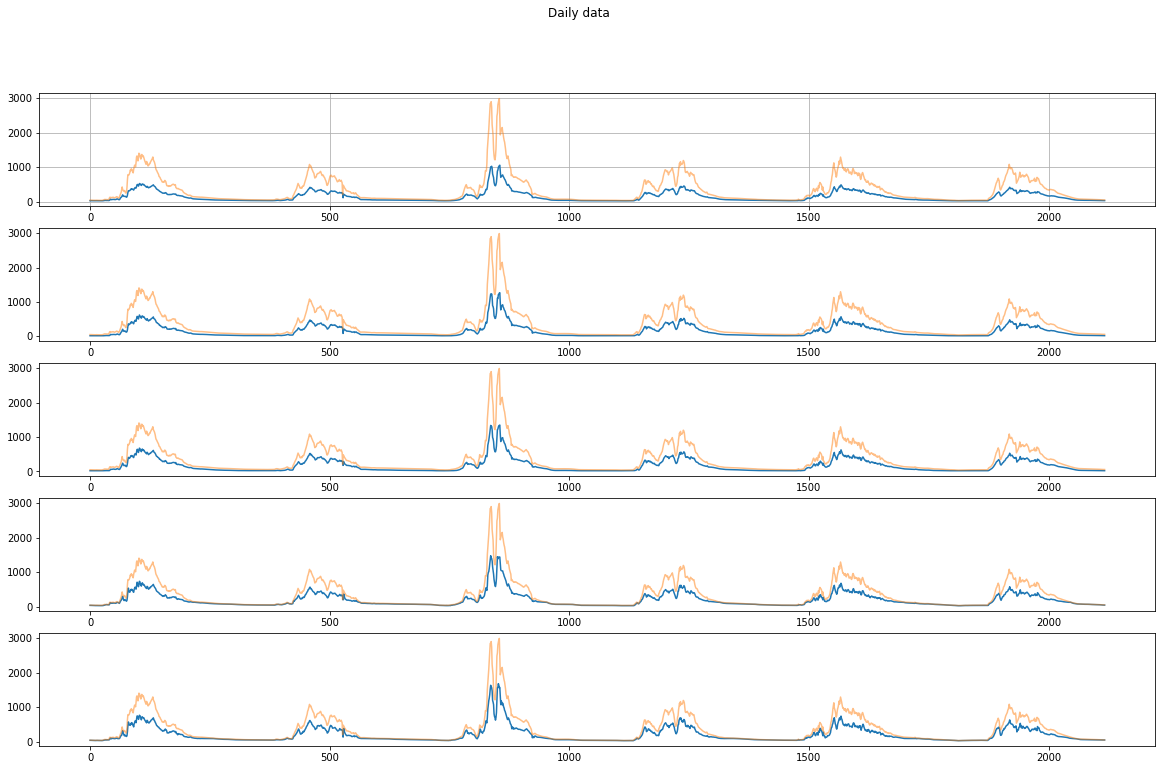

In [0]:
fig, axs = plt.subplots(5,figsize=(20, 12))
fig.suptitle('Daily data')

axs[0].plot(range(len(y_test_d.cpu().numpy())), y_pr_cnn_test_1_d)
axs[0].plot(range(len(y_test_d.cpu().numpy())), y_test_d.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[1].plot(range(len(y_test_d.cpu().numpy())), y_pr_cnn_test_2_d)
axs[1].plot(range(len(y_test_d.cpu().numpy())), y_test_d.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[2].plot(range(len(y_test_d.cpu().numpy())), y_pr_cnn_test_3_d)
axs[2].plot(range(len(y_test_d.cpu().numpy())), y_test_d.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[3].plot(range(len(y_test_d.cpu().numpy())), y_pr_cnn_test_4_d)
axs[3].plot(range(len(y_test_d.cpu().numpy())), y_test_d.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[4].plot(range(len(y_test_d.cpu().numpy())), y_pr_cnn_test_5_d)
axs[4].plot(range(len(y_test_d.cpu().numpy())), y_test_d.cpu().numpy(),alpha=0.5)
axs[0].grid()

plt.show()

Create the weekly plots for real and predicted data:

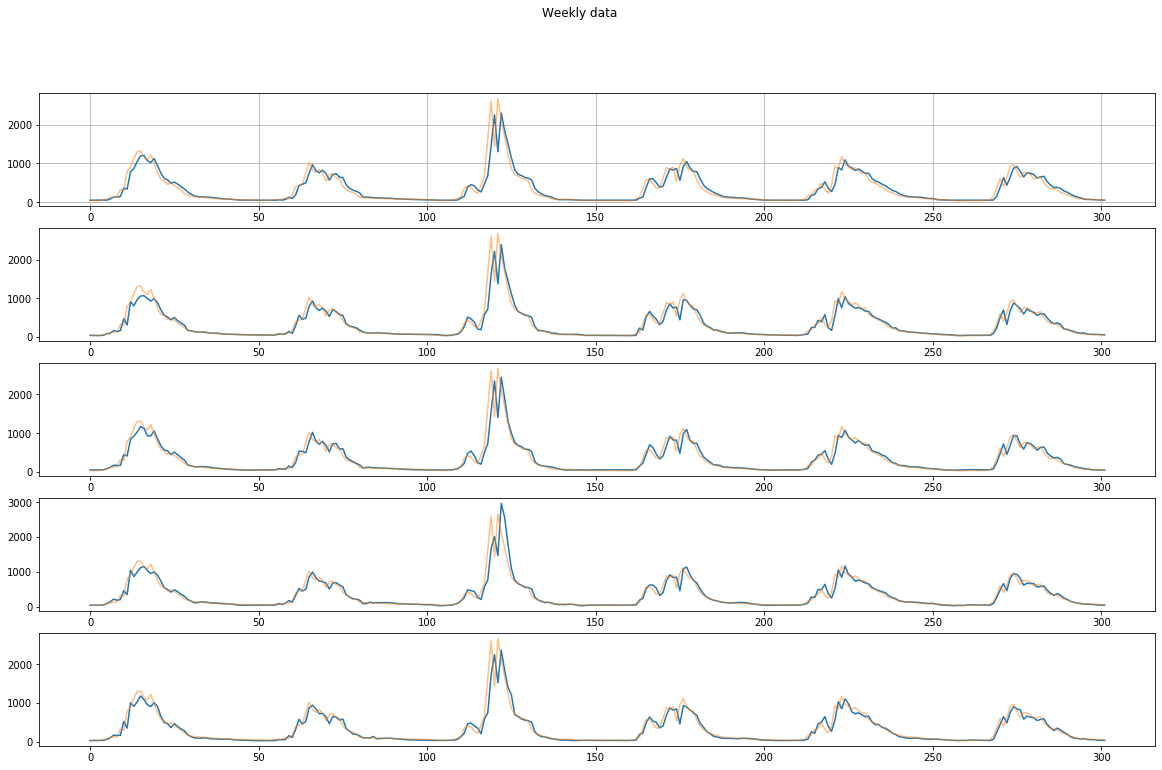

In [0]:
fig, axs = plt.subplots(5,figsize=(20, 12))
fig.suptitle('Weekly data')

axs[0].plot(range(len(y_test_w.cpu().numpy())), y_pr_cnn_test_1_w)
axs[0].plot(range(len(y_test_w.cpu().numpy())), y_test_w.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[1].plot(range(len(y_test_w.cpu().numpy())), y_pr_cnn_test_2_w)
axs[1].plot(range(len(y_test_w.cpu().numpy())), y_test_w.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[2].plot(range(len(y_test_w.cpu().numpy())), y_pr_cnn_test_3_w)
axs[2].plot(range(len(y_test_w.cpu().numpy())), y_test_w.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[3].plot(range(len(y_test_w.cpu().numpy())), y_pr_cnn_test_4_w)
axs[3].plot(range(len(y_test_w.cpu().numpy())), y_test_w.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[4].plot(range(len(y_test_w.cpu().numpy())), y_pr_cnn_test_5_w)
axs[4].plot(range(len(y_test_w.cpu().numpy())), y_test_w.cpu().numpy(),alpha=0.5)
axs[0].grid()

plt.show()

Create the monthly plots for real and predicted data:

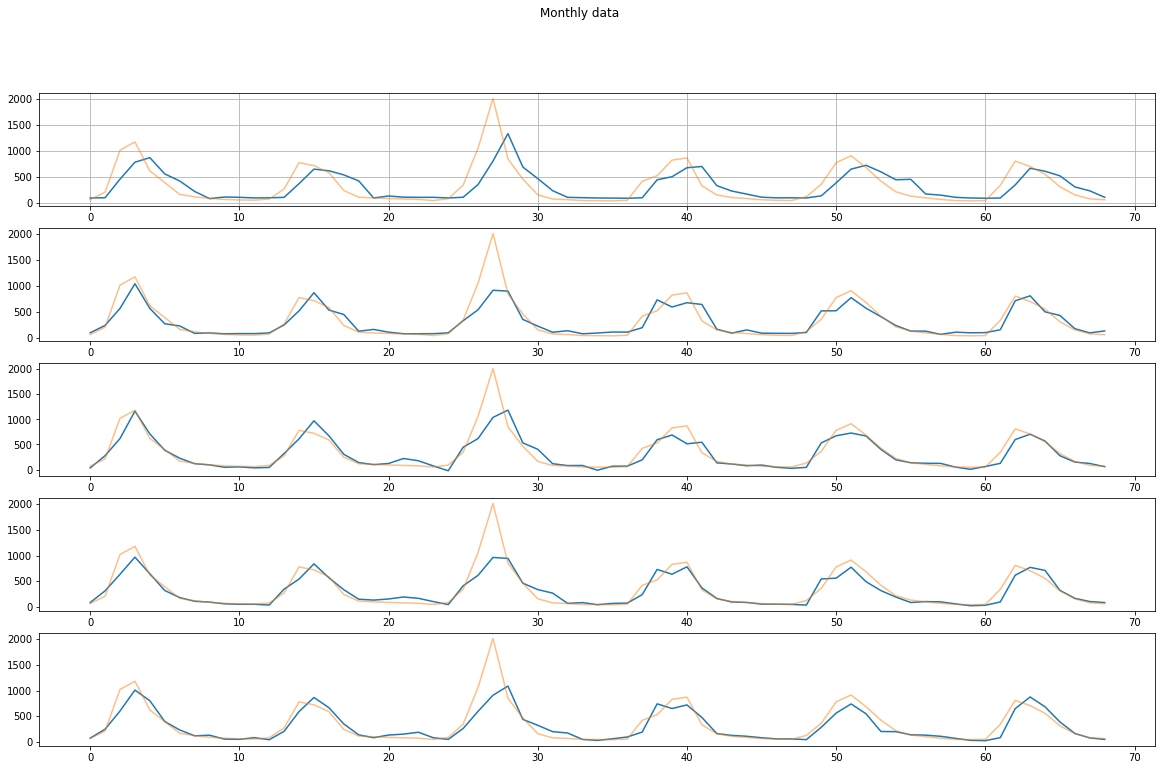

In [0]:
fig, axs = plt.subplots(5,figsize=(20, 12))
fig.suptitle('Monthly data')

axs[0].plot(range(len(y_test_m.cpu().numpy())), y_pr_cnn_test_1_m)
axs[0].plot(range(len(y_test_m.cpu().numpy())), y_test_m.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[1].plot(range(len(y_test_m.cpu().numpy())), y_pr_cnn_test_2_m)
axs[1].plot(range(len(y_test_m.cpu().numpy())), y_test_m.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[2].plot(range(len(y_test_m.cpu().numpy())), y_pr_cnn_test_3_m)
axs[2].plot(range(len(y_test_m.cpu().numpy())), y_test_m.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[3].plot(range(len(y_test_m.cpu().numpy())), y_pr_cnn_test_4_m)
axs[3].plot(range(len(y_test_m.cpu().numpy())), y_test_m.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[4].plot(range(len(y_test_m.cpu().numpy())), y_pr_cnn_test_5_m)
axs[4].plot(range(len(y_test_m.cpu().numpy())), y_test_m.cpu().numpy(),alpha=0.5)
axs[0].grid()

plt.show()

Create the daily plots for real and predicted data (LSTM):

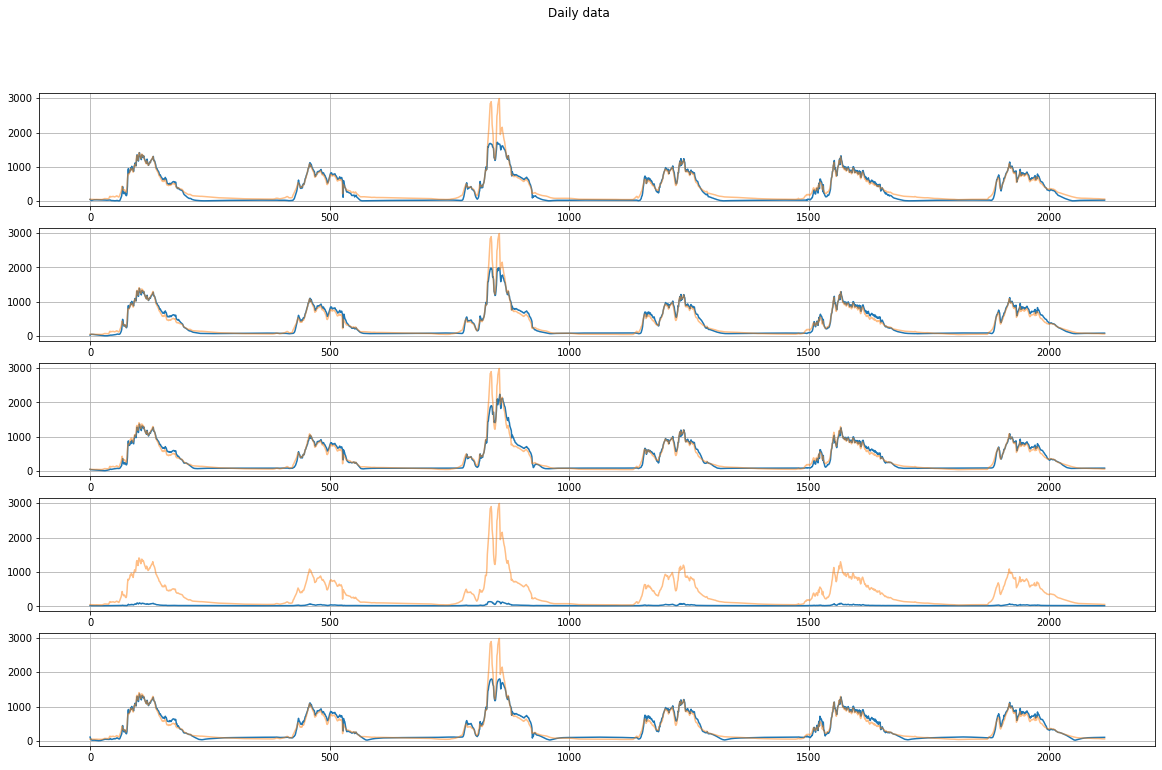

In [0]:
fig, axs = plt.subplots(5,figsize=(20, 12))
fig.suptitle('Daily data')

axs[0].plot(range(len(y_test_d.cpu().numpy())), y_pr_lstm_test_1_d)
axs[0].plot(range(len(y_test_d.cpu().numpy())), y_test_d.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[1].plot(range(len(y_test_d.cpu().numpy())), y_pr_lstm_test_2_d)
axs[1].plot(range(len(y_test_d.cpu().numpy())), y_test_d.cpu().numpy(),alpha=0.5)
axs[1].grid()

axs[2].plot(range(len(y_test_d.cpu().numpy())), y_pr_lstm_test_3_d)
axs[2].plot(range(len(y_test_d.cpu().numpy())), y_test_d.cpu().numpy(),alpha=0.5)
axs[2].grid()

axs[3].plot(range(len(y_test_d.cpu().numpy())), y_pr_lstm_test_4_d)
axs[3].plot(range(len(y_test_d.cpu().numpy())), y_test_d.cpu().numpy(),alpha=0.5)
axs[3].grid()

axs[4].plot(range(len(y_test_d.cpu().numpy())), y_pr_lstm_test_5_d)
axs[4].plot(range(len(y_test_d.cpu().numpy())), y_test_d.cpu().numpy(),alpha=0.5)
axs[4].grid()

plt.show()

Create the weekly plots for real and predicted data (LSTM):

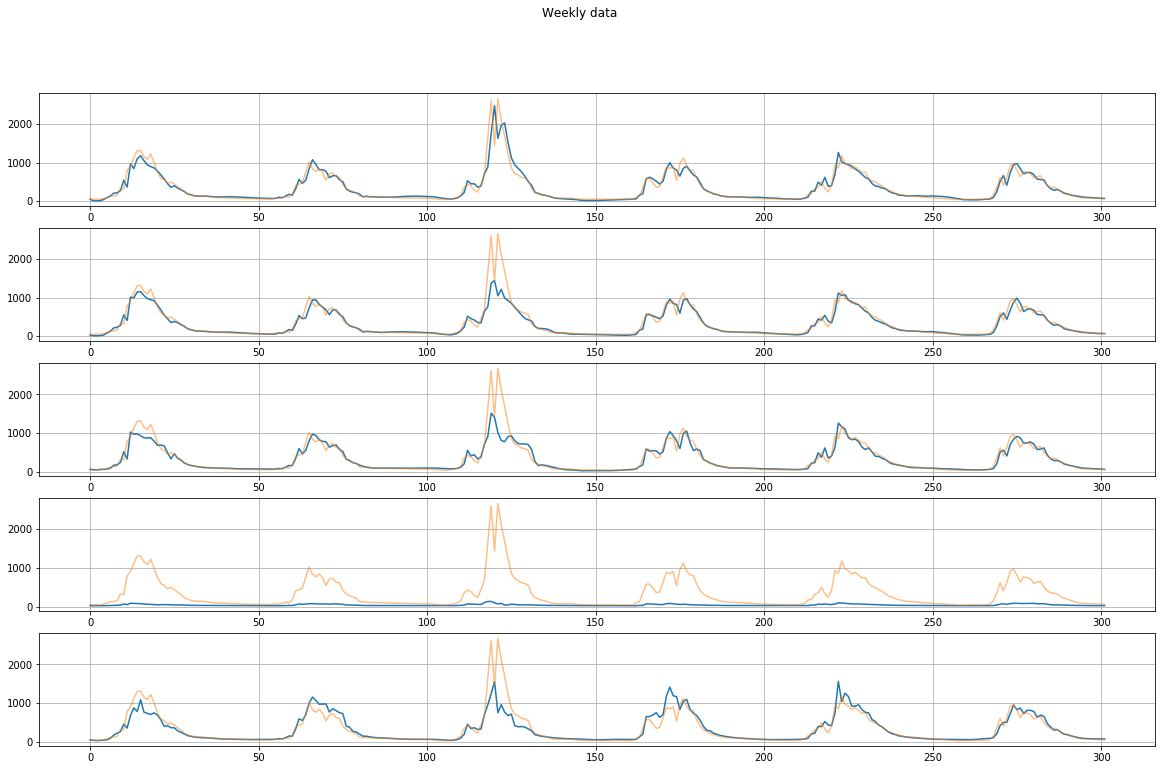

In [0]:
fig, axs = plt.subplots(5,figsize=(20, 12))
fig.suptitle('Weekly data')

axs[0].plot(range(len(y_test_w.cpu().numpy())), y_pr_lstm_test_1_w)
axs[0].plot(range(len(y_test_w.cpu().numpy())), y_test_w.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[1].plot(range(len(y_test_w.cpu().numpy())), y_pr_lstm_test_2_w)
axs[1].plot(range(len(y_test_w.cpu().numpy())), y_test_w.cpu().numpy(),alpha=0.5)
axs[1].grid()

axs[2].plot(range(len(y_test_w.cpu().numpy())), y_pr_lstm_test_3_w)
axs[2].plot(range(len(y_test_w.cpu().numpy())), y_test_w.cpu().numpy(),alpha=0.5)
axs[2].grid()

axs[3].plot(range(len(y_test_w.cpu().numpy())), y_pr_lstm_test_4_w)
axs[3].plot(range(len(y_test_w.cpu().numpy())), y_test_w.cpu().numpy(),alpha=0.5)
axs[3].grid()

axs[4].plot(range(len(y_test_w.cpu().numpy())), y_pr_lstm_test_5_w)
axs[4].plot(range(len(y_test_w.cpu().numpy())), y_test_w.cpu().numpy(),alpha=0.5)
axs[4].grid()

plt.show()

Create the monthly plots for real and predicted data (LSTM):

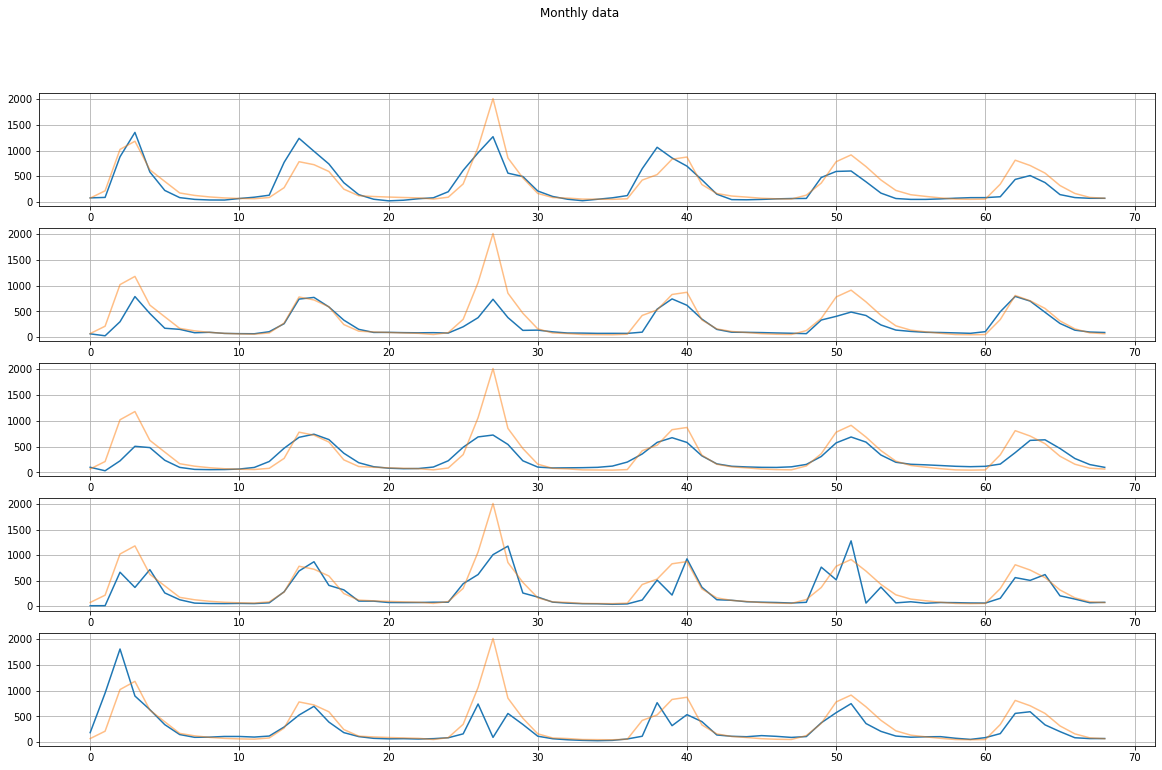

In [0]:
fig, axs = plt.subplots(5,figsize=(20, 12))
fig.suptitle('Monthly data')

axs[0].plot(range(len(y_test_m.cpu().numpy())), y_pr_lstm_test_1_m)
axs[0].plot(range(len(y_test_m.cpu().numpy())), y_test_m.cpu().numpy(),alpha=0.5)
axs[0].grid()

axs[1].plot(range(len(y_test_m.cpu().numpy())), y_pr_lstm_test_2_m)
axs[1].plot(range(len(y_test_m.cpu().numpy())), y_test_m.cpu().numpy(),alpha=0.5)
axs[1].grid()

axs[2].plot(range(len(y_test_m.cpu().numpy())), y_pr_lstm_test_3_m)
axs[2].plot(range(len(y_test_m.cpu().numpy())), y_test_m.cpu().numpy(),alpha=0.5)
axs[2].grid()

axs[3].plot(range(len(y_test_m.cpu().numpy())), y_pr_lstm_test_4_m)
axs[3].plot(range(len(y_test_m.cpu().numpy())), y_test_m.cpu().numpy(),alpha=0.5)
axs[3].grid()

axs[4].plot(range(len(y_test_m.cpu().numpy())), y_pr_lstm_test_5_m)
axs[4].plot(range(len(y_test_m.cpu().numpy())), y_test_m.cpu().numpy(),alpha=0.5)
axs[4].grid()

plt.show()

Scatter plot for the observed versus the simulated stream-ﬂow for the testing phase.

Create the daily scatter plots for real and predicted data (CNN):

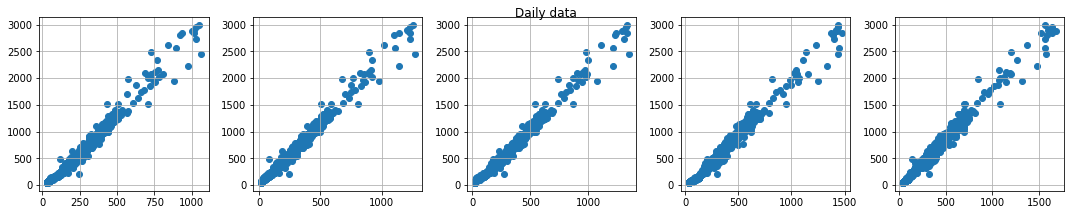

In [0]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Daily data')
plt.tight_layout()

axs[0].scatter(y_pr_cnn_test_1_d,y_test_d.cpu().numpy())
axs[0].grid()
axs[1].scatter(y_pr_cnn_test_2_d,y_test_d.cpu().numpy())
axs[1].grid()
axs[2].scatter(y_pr_cnn_test_3_d,y_test_d.cpu().numpy())
axs[2].grid()
axs[3].scatter(y_pr_cnn_test_4_d,y_test_d.cpu().numpy())
axs[3].grid()
axs[4].scatter(y_pr_cnn_test_5_d,y_test_d.cpu().numpy())
axs[4].grid()

plt.show()

Create the weekly scatter plots for real and predicted data (CNN):

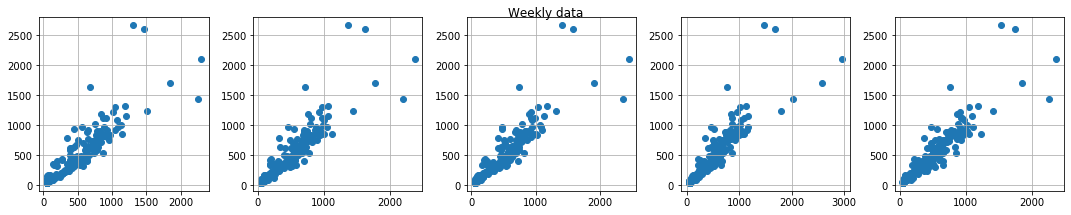

In [0]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Weekly data')
plt.tight_layout()

axs[0].scatter(y_pr_cnn_test_1_w,y_test_w.cpu().numpy())
axs[0].grid()
axs[1].scatter(y_pr_cnn_test_2_w,y_test_w.cpu().numpy())
axs[1].grid()
axs[2].scatter(y_pr_cnn_test_3_w,y_test_w.cpu().numpy())
axs[2].grid()
axs[3].scatter(y_pr_cnn_test_4_w,y_test_w.cpu().numpy())
axs[3].grid()
axs[4].scatter(y_pr_cnn_test_5_w,y_test_w.cpu().numpy())
axs[4].grid()

plt.show()

Create the monthly scatter plots for real and predicted data (CNN):

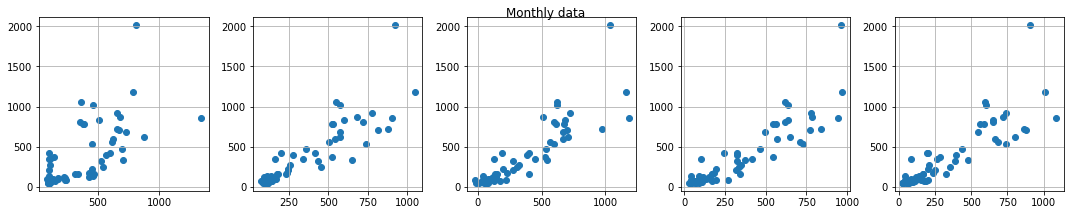

In [0]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Monthly data')
plt.tight_layout()

axs[0].scatter(y_pr_cnn_test_1_m,y_test_m.cpu().numpy())
axs[0].grid()
axs[1].scatter(y_pr_cnn_test_2_m,y_test_m.cpu().numpy())
axs[1].grid()
axs[2].scatter(y_pr_cnn_test_3_m,y_test_m.cpu().numpy())
axs[2].grid()
axs[3].scatter(y_pr_cnn_test_4_m,y_test_m.cpu().numpy())
axs[3].grid()
axs[4].scatter(y_pr_cnn_test_5_m,y_test_m.cpu().numpy())
axs[4].grid()

plt.show()

Create the daily scatter plots for real and predicted data (LSTM):

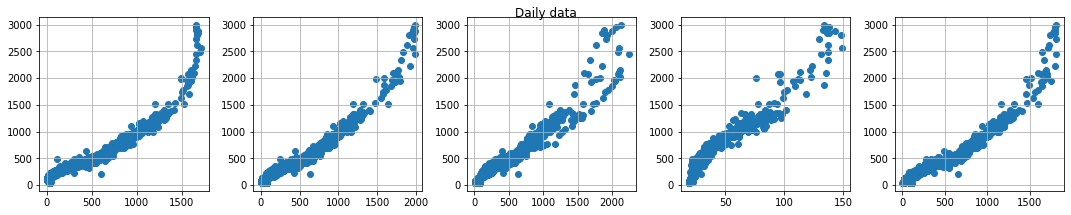

In [0]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Daily data')
plt.tight_layout()

axs[0].scatter(y_pr_lstm_test_1_d,y_test_d.cpu().numpy())
axs[0].grid()
axs[1].scatter(y_pr_lstm_test_2_d,y_test_d.cpu().numpy())
axs[1].grid()
axs[2].scatter(y_pr_lstm_test_3_d,y_test_d.cpu().numpy())
axs[2].grid()
axs[3].scatter(y_pr_lstm_test_4_d,y_test_d.cpu().numpy())
axs[3].grid()
axs[4].scatter(y_pr_lstm_test_5_d,y_test_d.cpu().numpy())
axs[4].grid()

plt.show()

Create the weekly scatter plots for real and predicted data (LSTM):

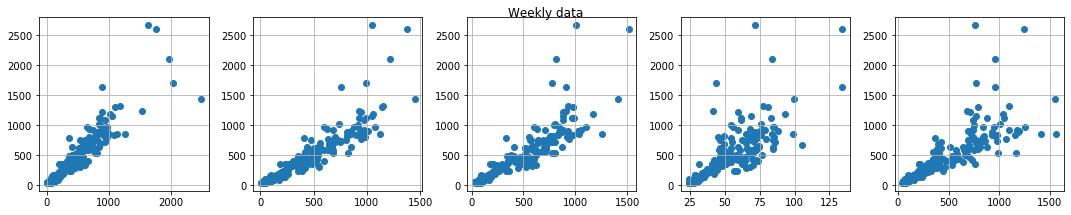

In [0]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Weekly data')
plt.tight_layout()

axs[0].scatter(y_pr_lstm_test_1_w,y_test_w.cpu().numpy())
axs[0].grid()
axs[1].scatter(y_pr_lstm_test_2_w,y_test_w.cpu().numpy())
axs[1].grid()
axs[2].scatter(y_pr_lstm_test_3_w,y_test_w.cpu().numpy())
axs[2].grid()
axs[3].scatter(y_pr_lstm_test_4_w,y_test_w.cpu().numpy())
axs[3].grid()
axs[4].scatter(y_pr_lstm_test_5_w,y_test_w.cpu().numpy())
axs[4].grid()

plt.show()

Create the monthly scatter plots for real and predicted data (LSTM):

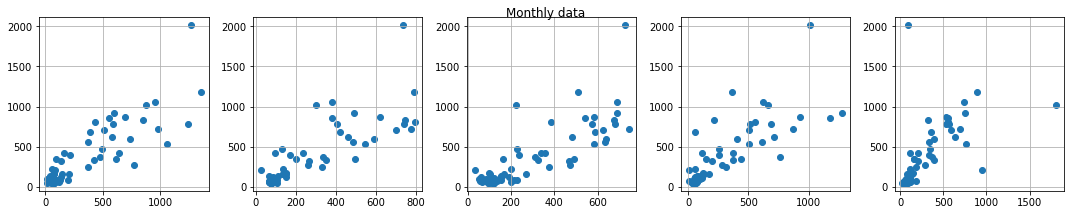

In [0]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Monthly data')
plt.tight_layout()

axs[0].scatter(y_pr_lstm_test_1_m,y_test_m.cpu().numpy())
axs[0].grid()
axs[1].scatter(y_pr_lstm_test_2_m,y_test_m.cpu().numpy())
axs[1].grid()
axs[2].scatter(y_pr_lstm_test_3_m,y_test_m.cpu().numpy())
axs[2].grid()
axs[3].scatter(y_pr_lstm_test_4_m,y_test_m.cpu().numpy())
axs[3].grid()
axs[4].scatter(y_pr_lstm_test_5_m,y_test_m.cpu().numpy())
axs[4].grid()

plt.show()

Relative error distribution for the testing phase.

Create the daily distribultion plots for real and predicted data (CNN):

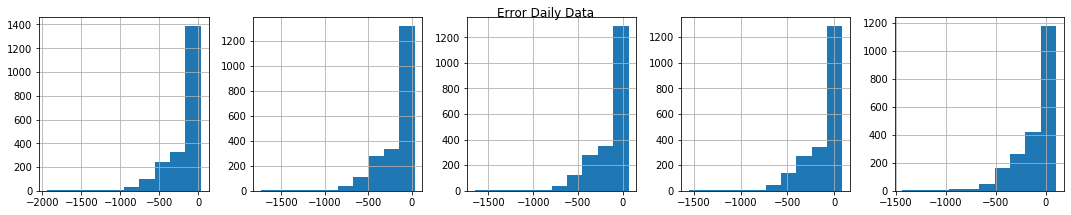

In [0]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Error Daily Data')
plt.tight_layout()

axs[0].hist(y_pr_cnn_test_1_d-y_test_d.view(-1).cpu().numpy())
axs[0].grid()
axs[1].hist(y_pr_cnn_test_2_d-y_test_d.view(-1).cpu().numpy())
axs[1].grid()
axs[2].hist(y_pr_cnn_test_3_d-y_test_d.view(-1).cpu().numpy())
axs[2].grid()
axs[3].hist(y_pr_cnn_test_4_d-y_test_d.view(-1).cpu().numpy())
axs[3].grid()
axs[4].hist(y_pr_cnn_test_5_d-y_test_d.view(-1).cpu().numpy())
axs[4].grid()

plt.show()

Create the weekly distribultion plots for real and predicted data (CNN):

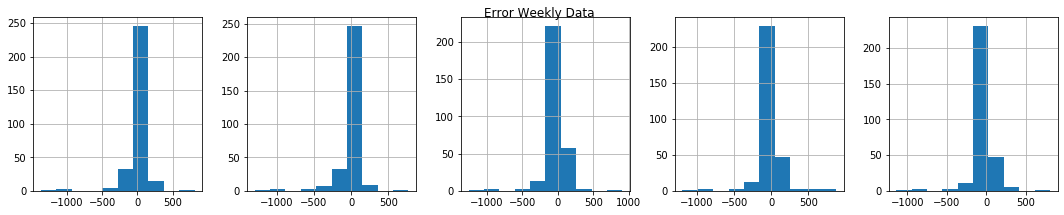

In [67]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Error Weekly Data')
plt.tight_layout()

axs[0].hist(y_pr_cnn_test_1_w-y_test_w.view(-1).cpu().numpy())
axs[0].grid()
axs[1].hist(y_pr_cnn_test_2_w-y_test_w.view(-1).cpu().numpy())
axs[1].grid()
axs[2].hist(y_pr_cnn_test_3_w-y_test_w.view(-1).cpu().numpy())
axs[2].grid()
axs[3].hist(y_pr_cnn_test_4_w-y_test_w.view(-1).cpu().numpy())
axs[3].grid()
axs[4].hist(y_pr_cnn_test_5_w-y_test_w.view(-1).cpu().numpy())
axs[4].grid()

plt.show()

Create the monthly distribultion plots for real and predicted data (CNN):

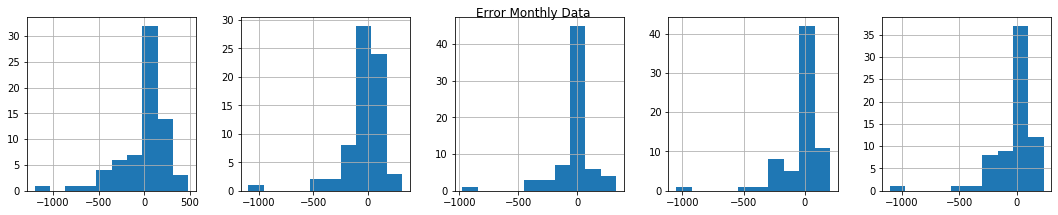

In [0]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Error Monthly Data')
plt.tight_layout()

axs[0].hist(y_pr_cnn_test_1_m-y_test_m.view(-1).cpu().numpy())
axs[0].grid()
axs[1].hist(y_pr_cnn_test_2_m-y_test_m.view(-1).cpu().numpy())
axs[1].grid()
axs[2].hist(y_pr_cnn_test_3_m-y_test_m.view(-1).cpu().numpy())
axs[2].grid()
axs[3].hist(y_pr_cnn_test_4_m-y_test_m.view(-1).cpu().numpy())
axs[3].grid()
axs[4].hist(y_pr_cnn_test_5_m-y_test_m.view(-1).cpu().numpy())
axs[4].grid()

plt.show()

Create the daily distribultion plots for real and predicted data (LSTM):

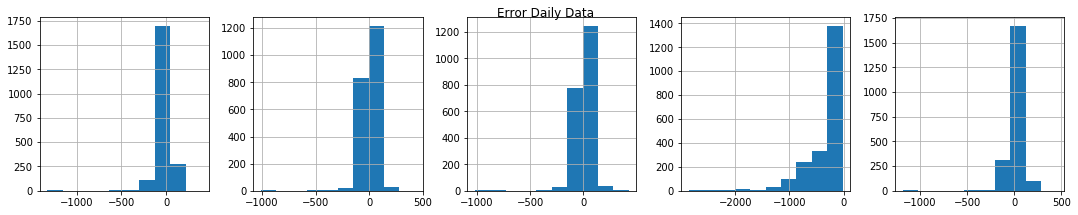

In [0]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Error Daily Data')
plt.tight_layout()

axs[0].hist(y_pr_lstm_test_1_d-y_test_d.view(-1).cpu().numpy())
axs[0].grid()
axs[1].hist(y_pr_lstm_test_2_d-y_test_d.view(-1).cpu().numpy())
axs[1].grid()
axs[2].hist(y_pr_lstm_test_3_d-y_test_d.view(-1).cpu().numpy())
axs[2].grid()
axs[3].hist(y_pr_lstm_test_4_d-y_test_d.view(-1).cpu().numpy())
axs[3].grid()
axs[4].hist(y_pr_lstm_test_5_d-y_test_d.view(-1).cpu().numpy())
axs[4].grid()

plt.show()

Create the weekly distribultion plots for real and predicted data (LSTM):

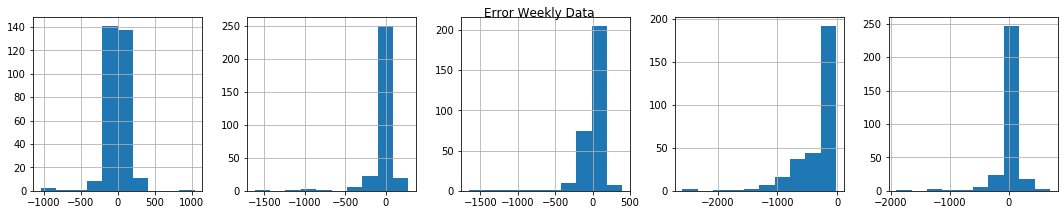

In [0]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Error Weekly Data')
plt.tight_layout()

axs[0].hist(y_pr_lstm_test_1_w-y_test_w.view(-1).cpu().numpy())
axs[0].grid()
axs[1].hist(y_pr_lstm_test_2_w-y_test_w.view(-1).cpu().numpy())
axs[1].grid()
axs[2].hist(y_pr_lstm_test_3_w-y_test_w.view(-1).cpu().numpy())
axs[2].grid()
axs[3].hist(y_pr_lstm_test_4_w-y_test_w.view(-1).cpu().numpy())
axs[3].grid()
axs[4].hist(y_pr_lstm_test_5_w-y_test_w.view(-1).cpu().numpy())
axs[4].grid()

plt.show()

Create the monthly distribultion plots for real and predicted data (LSTM):

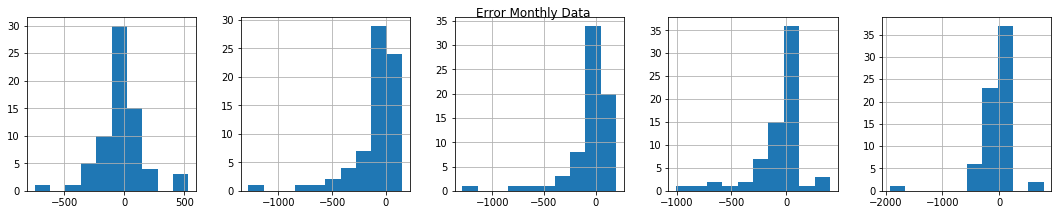

In [0]:
fig, axs = plt.subplots(1,5,figsize=(15, 3))
fig.suptitle('Error Monthly Data')
plt.tight_layout()

axs[0].hist(y_pr_lstm_test_1_m-y_test_m.view(-1).cpu().numpy())
axs[0].grid()
axs[1].hist(y_pr_lstm_test_2_m-y_test_m.view(-1).cpu().numpy())
axs[1].grid()
axs[2].hist(y_pr_lstm_test_3_m-y_test_m.view(-1).cpu().numpy())
axs[2].grid()
axs[3].hist(y_pr_lstm_test_4_m-y_test_m.view(-1).cpu().numpy())
axs[3].grid()
axs[4].hist(y_pr_lstm_test_5_m-y_test_m.view(-1).cpu().numpy())
axs[4].grid()

plt.show()